In [1]:
from simulation import * 
from pulse_encoding import * 
from gate_population import * 
import math 
from qiskit.circuit import Instruction

In [2]:
noise_config = {
    'thermal_relaxation': {
        't1': 50e3,        
        't2': 30e3,       
        'time': 100      
    },
    'depolarization': {
        'probability': 0.02  
    },
    'amplitude_damping': {
        'gamma': 0.05         
    },
    'phase_damping': {
        'gamma': 0.05        
    },
    'coherent_unitary': {
        'theta_error': 0.01   
    }
}


qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.barrier()

class_ = FullSimulation(
    circuit = qc, num_individuals = 100, approx_length = 4 , 
    max_gate_reps = 3, basis_gates=[XGate(), YGate(), ZGate()], 
    basis_names=['x', 'y', 'z'], verbose=False
)

probabilities = class_.full_pop_noise_sim(noise_config = noise_config, shots = 1024)

In [162]:
import numpy as np 
import matplotlib.pyplot as plt

class GeneticAlgorithm:

    def __init__(self, simulation_class, population_size, generations, mutation_rate=0.1, noise_config=None, verbose=True):
        """
        A genetic algorithm to evolve a population of dynamical decoupling sequences.
        
        - simulation_class: An instance of the IndividualSimulation class to run simulations.
        - population_size: The number of individuals (DD sequences) in the population.
        - generations: The number of generations for the GA to run.
        - mutation_rate: Probability of mutation occurring in offspring.
        - verbose: If True, prints out generation details.

        """
        self.simulation_class = simulation_class
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.verbose = verbose
        self.noise_config = noise_config
        self.history = {'mitigated': [], 'unmitigated': [], 'max_mitigated': []}

    def generate_population(self):
        return self.simulation_class.generate_population()

    def fitness(self, individual):
        final_circuit, durations = self.simulation_class.generate_circuit(individual)
        if not self.noise_config:
            prob_unmitigated, probability, _ = self.simulation_class.fake_backend_sim()
        else:
            prob_unmitigated, probability = self.simulation_class.simulation(noise_config=self.noise_config)
        return probability, prob_unmitigated

    def selection(self, population, fitnesses):
        total_fitness = sum(fitnesses)
        probabilities = [fitness / total_fitness for fitness in fitnesses]
        selected = random.choices(population, weights=probabilities, k=self.population_size)
        return selected

    def crossover(self, parent1, parent2):
        subsequences1 = self.simulation_class.split_into_identity_subsequences(parent1)
        subsequences2 = self.simulation_class.split_into_identity_subsequences(parent2)

        if subsequences1 and subsequences2:
            subseq1 = random.choice(subsequences1)
            subseq2 = random.choice(subsequences2)
        else:
            raise ValueError("Subsequences were not properly formed.")
        
        child = subseq1 + subseq2

        if not self.simulation_class.check_identity(child):
            child = self.simulation_class.fix_to_identity(child)

        return child

    def mutate(self, individual, max_mutation=4):
        if random.random() < self.mutation_rate:
            gate = random.choices(['X', 'Y', 'Z'])
            mutation_amount = random.choice(np.arange(2, max_mutation, 2))
            
            idxs = []
            count = 0
            for operator in range(len(individual)): 
                if individual[operator].name == gate[0].lower() and count < mutation_amount: 
                    idxs.append(operator)
                    count += 1
            if idxs:
                for index in sorted(idxs, reverse=True):
                    del individual[index]
        return individual

    def evolve(self):
        population, _ = self.generate_population()
        population_size = self.population_size

        for generation in range(self.generations):
            fitnesses = [self.fitness(individual) for individual in population]
            mitigated_fitnesses = [f[0] for f in fitnesses]
            unmitigated_fitnesses = [f[1] for f in fitnesses]
            
            avg_mitigated_fitness = sum(mitigated_fitnesses) / len(mitigated_fitnesses)
            avg_unmitigated_fitness = sum(unmitigated_fitnesses) / len(unmitigated_fitnesses)
            max_mitigated_fitness = max(mitigated_fitnesses)
            
            self.history['mitigated'].append(avg_mitigated_fitness)
            self.history['unmitigated'].append(avg_unmitigated_fitness)
            self.history['max_mitigated'].append(max_mitigated_fitness)

            if self.verbose:
                print(f"Generation {generation}: Avg mitigated fitness = {avg_mitigated_fitness}, Avg unmitigated fitness = {avg_unmitigated_fitness}, Max mitigated fitness = {max_mitigated_fitness}")

            remaining_population_size = random.randint((population_size + 1) // 2, max(1, population_size))
            population_size = remaining_population_size

            selected_population = self.selection(population, mitigated_fitnesses)
            selected_population = selected_population[:remaining_population_size]

            next_population = []
            for i in range(0, len(selected_population), 2):
                parent1 = selected_population[i]
                parent2 = selected_population[(i + 1) % len(selected_population)]
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                next_population.append(child)

            population = next_population

        return population

    def plot_progress(self):
        plt.plot(range(self.generations), self.history['mitigated'], label='Mitigated Avg.')
        plt.plot(range(self.generations), self.history['unmitigated'], label='Unmitigated Avg.', linestyle='--')
        plt.plot(range(self.generations), self.history['max_mitigated'], label='Max Mitigated', linestyle='-.')
        plt.title('Genetic Algorithm Progress')
        plt.xlabel('Generation')
        plt.ylabel('Success Probability')
        plt.legend()
        plt.show()


Individual 1
 ['z', 'z', 'y', 'y', 'x', 'x', 'y', 'z', 'y', 'y', 'z', 'x', 'x', 'z', 'y', 'x', 'y', 'z', 'x', 'y', 'z', 'z', 'z', 'x', 'z', 'y', 'x', 'y', 'y', 'x', 'x', 'x', 'z', 'y', 'z', 'y', 'x', 'x', 'z', 'x', 'y', 'y', 'y', 'y', 'y', 'y', 'x', 'y', 'y', 'x', 'x', 'y', 'x', 'z', 'x', 'y', 'y', 'x', 'y', 'z', 'x', 'z', 'x', 'x', 'x', 'x', 'x', 'y', 'z', 'x', 'y', 'x', 'y', 'y', 'y', 'y', 'z', 'z', 'x', 'x', 'z', 'y', 'y', 'x', 'y', 'z', 'z', 'x', 'x', 'z', 'z', 'x', 'y', 'x', 'y', 'y', 'x', 'x', 'x', 'z', 'z', 'z', 'x', 'y', 'y', 'y', 'z', 'z', 'z', 'x', 'z', 'z', 'x', 'y', 'y', 'x']
Individual 2
 ['y', 'x', 'z', 'x', 'y', 'x', 'x', 'z', 'x', 'y', 'y', 'x', 'z', 'z', 'x', 'z', 'x', 'z', 'z', 'y', 'z', 'x', 'z', 'y', 'x', 'z', 'y', 'y', 'x', 'x', 'x', 'y', 'y', 'z', 'z', 'z', 'z', 'z', 'x', 'z', 'z', 'y', 'z', 'x', 'x', 'y', 'y', 'z', 'x', 'y', 'y', 'y', 'x', 'x', 'z', 'y', 'y', 'y', 'z', 'y', 'y', 'y', 'y', 'x', 'y', 'y', 'x', 'y', 'y', 'z', 'x', 'y']
Individual 3
 ['x', 'z', 'x', 

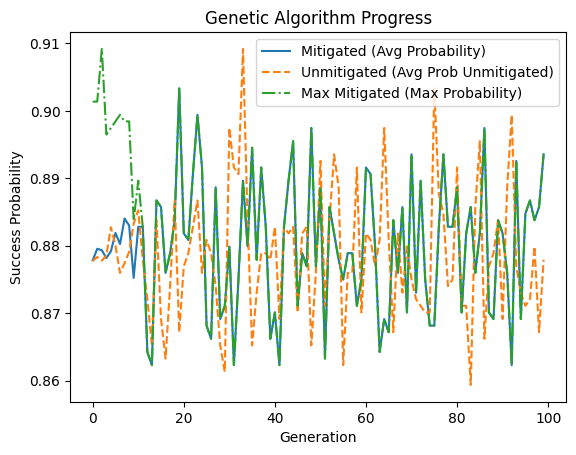

OPTIMUM INDIVIDUAL
[[Instruction(name='x', num_qubits=1, num_clbits=0, params=[array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])]), Instruction(name='x', num_qubits=1, num_clbits=0, params=[array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])]), Instruction(name='x', num_qubits=1, num_clbits=0, params=[array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])]), Instruction(name='x', num_qubits=1, num_clbits=0, params=[array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])])]]


In [161]:
qc_example = QuantumCircuit(4)
qc_example.h(0)
qc_example.cx(0, 1)
qc_example.cx(1, 2)
qc_example.cx(2, 3)
qc_example.barrier()

simulation_instance = IndividualSimulation(qc_example, num_individuals=100, length_range=[50, 100], max_gate_reps=100, verbose=True)

ga = GeneticAlgorithm(simulation_instance, population_size=100, generations=100, mutation_rate=0.1, verbose=True)
final_population = ga.evolve()

ga.plot_progress()

print('OPTIMUM INDIVIDUAL')
print(final_population)

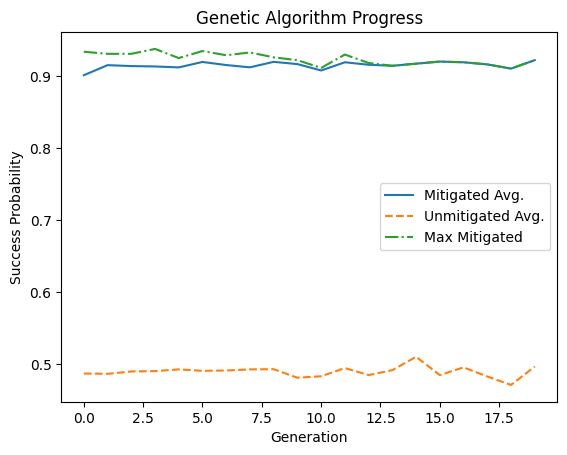

OPTIMUM INDIVIDUAL
[[Instruction(name='z', num_qubits=1, num_clbits=0, params=[array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])]), Instruction(name='z', num_qubits=1, num_clbits=0, params=[array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])]), Instruction(name='z', num_qubits=1, num_clbits=0, params=[array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])]), Instruction(name='z', num_qubits=1, num_clbits=0, params=[array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])])]]


In [164]:
noise_config = {
        'thermal_relaxation': {'t1': 50e3, 't2': 75e3, 'time': 100},
        'depolarization': {'probability': 0.01}
    }

qc_example = QuantumCircuit(4)
qc_example.h(0)
qc_example.cx(0, 1)
qc_example.cx(1, 2)
qc_example.cx(2, 3)
qc_example.barrier()

simulation_instance = IndividualSimulation(qc_example, num_individuals=100, length_range=[50, 100], max_gate_reps=100, verbose=False)

ga = GeneticAlgorithm(simulation_instance, population_size=100, generations = 20, mutation_rate=0.2, noise_config = noise_config, verbose=False)
final_population = ga.evolve()

ga.plot_progress()

print('OPTIMUM INDIVIDUAL')
print(final_population)